In [1]:
!uv pip install numba==0.56.4  matplotlib==3.8.0 networkx==3.1 numpy==1.23.5 pandas==2.1.4 scikit-learn==1.3.0 scipy==1.11.4 seaborn==0.12.2 ortools==9.8.3296 gdown tigramite

Resolved 39 packages in 280ms                                        
⠙ Preparing packages... (0/19)                                                  
⠙ Preparing packages... (0/19)-------     0 B/182.90 KiB                
gdown      ------------------------------     0 B/17.81 KiB
⠙ Preparing packages... (0/19)-------     0 B/182.90 KiB                
pysocks    ------------------------------     0 B/16.33 KiB
gdown      ------------------------------     0 B/17.81 KiB
⠙ Preparing packages... (0/19)-------     0 B/182.90 KiB                
pysocks    ------------------------------     0 B/16.33 KiB
gdown      ------------------------------     0 B/17.81 KiB
⠙ Preparing packages... (0/19)------- 14.91 KiB/182.90 KiB              
pysocks    ------------------------------     0 B/16.33 KiB
gdown      ------------------------------ 14.92 KiB/17.81 KiB
⠙ Preparing packages... (0/19)------- 14.91 KiB/182.90 KiB              
pysocks    ------------------------------ 14.88 KiB/16.33 KiB


# Full Process for Regime Classification
1. PCMCI (entirely statistical process, no ML) is run on the data to identify the causal structure.
   1. PCMCI is restricted to identifying causal links from climate variables from the past `tau_min` to `tau_max` days to climate variables for the current day.
   2. The result is a set of unweighted directed edges (causal links) from the past to the present also known as an SCM (Structural Causal Model).
2. To determine the functions of the SCM (numerical relationships between present variables and their parents), a model is trained for each node to predict the present variables from their parents.
3. The difference between the predicted and actual values of the present variables is calculated.
4. The resulting residuals are used to train a clustering algorithm (e.g., KMeans) to classify the present variables into regimes.

In [2]:
# imports
import copy

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime, timedelta

# Metrics and Evaluation
from sklearn.metrics import confusion_matrix

In [3]:
# Data preprocessing and graph visualization
from tigramite import data_processing as pp
from tigramite import plotting as tp
# Causal discovery
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.pcmci import PCMCI
from tigramite.models import Models
# from rpcmci import RPCMCI
import networkx as nx
# Linear model
from sklearn.linear_model import LinearRegression

In [4]:
def reshape_and_resample_df(filename, val_type='seasonal_dtr_val_std', sample_freq='3D', sampling_type='mean',
                            fill_missing=False, fill_missing_value=999., use_evap=False):
    # Load DataFrame
    df = pd.read_csv(filename)
    freq = int(sample_freq[0])

    # Convert 'VAC' values
    vac_conversion = {'a': 1, 'b': 2, 'c': 3, 'd': 4, '0': 0}
    df['VAC'] = df['VAC'].replace(vac_conversion).astype(float)

    # Pivot the DataFrame
    pivoted_df = df.pivot(index='date', columns='var', values=val_type)
    pivoted_df.index = pd.to_datetime(pivoted_df.index)

    # only keep years starting from 1990
    all_days_to_keep = np.arange(datetime(1993, 3, 1), datetime(2022, 9, 30),
                                 timedelta(days=1)).astype(datetime)
    dates_to_keep = [i for i in all_days_to_keep if i in pivoted_df.index]
    pivoted_df = pivoted_df.loc[dates_to_keep]

    if use_evap:
        pivoted_df['evap'] = pivoted_df['slhf'] / pivoted_df['slhf'] + \
        pivoted_df['sshf']

    # Extract and prepare 'VAC' column
    date_to_vac = df.drop_duplicates(subset='date').set_index('date')['VAC']
    date_to_vac.index = pd.to_datetime(date_to_vac.index)
    date_to_vac = date_to_vac.loc[dates_to_keep]

    if fill_missing:
        date_array = pivoted_df.index

        # fill in missing days with 999.
        filled_df = pd.DataFrame(fill_missing_value, index=all_days_to_keep,
                                 columns=pivoted_df.columns)
        filled_df.index = pd.to_datetime(filled_df.index).strftime('%Y-%m-%d')

        filled_vac_df = pd.Series(fill_missing_value, index=all_days_to_keep)
        filled_vac_df.index = pd.to_datetime(
            filled_vac_df.index).strftime('%Y-%m-%d')

        for day in filled_df.index:
            if day in date_array:
                filled_df.loc[day] = pivoted_df.loc[day]
                filled_vac_df.loc[day] = date_to_vac.loc[day]

        pivoted_df = filled_df
        date_to_vac = filled_vac_df

    # Resample data
    if sampling_type == 'mean':
        resampled = pivoted_df.copy().resample(sample_freq).mean().dropna()
        resampled_vac = np.round(
            date_to_vac.resample(sample_freq).median().dropna())
    elif sampling_type == 'subsample':
        # Assuming 'sample_freq' contains a valid integer for frequency
        resampled = pivoted_df.copy().iloc[::freq]
        resampled_vac = date_to_vac.iloc[::freq]
    else:
        raise ValueError('This type of sampling is not supported!')

    # Assign 'VAC' values to the resampled DataFrame
    resampled['VAC'] = resampled_vac

    return resampled

In [5]:
def get_pandas_and_tigramite_dfs(filename, val_type='seasonal_dtr_val_std', sample_freq='1D', sampling_type='mean',
                                 vals_to_drop=None, fill_missing=False, fill_missing_value=999., use_evap=False):
    # Reshape and resample DataFrame
    pd_df = reshape_and_resample_df(filename, val_type=val_type,
                                    sample_freq=sample_freq,
                                    sampling_type=sampling_type,
                                    fill_missing=fill_missing,
                                    fill_missing_value=fill_missing_value,
                                    use_evap=use_evap)

    vac_values = pd_df['VAC'].copy().to_numpy()

    # rename columns
    pd_df = pd_df.rename(columns={'slhf': 'LH',
                                  'sshf': 'SH',
                                  'swvl123': 'SM',
                                  't2m': 'T2m',
                                  'tp': 'TP',
                                  'stream': 'Stream',
                                  'ssrd': 'SW'})

    # Drop specified columns if provided
    if vals_to_drop is not None:
        pd_df.drop(vals_to_drop, axis=1, inplace=True)
    
    # Sort the DataFrame by index
    pd_df.sort_index(inplace=True)

    # Convert to new DataFrame with appropriate column names
    tig_df = pp.DataFrame(pd_df.to_numpy(), var_names=pd_df.columns, missing_flag=999.)

    return pd_df, tig_df, vac_values

- Mean air temperature 2m above the ground (T2m),
- Root-zone (1m) soil moisture (SM),
- Surface sensible heat flux (SH), sign swapped to obtain positive upward fluxes,
- Surface latent heat flux (LH), sign swapped as for SH,
- Stream function at 250 hPa (Stream), describing atmospheric circulation patterns,
- Shortwave downward radiation (SW),
- Precipitation (TP),
- An expert guided regime classification index, i.e. the vegetation-atmosphere coupling (VAC) index (https://doi.org/10.1002/2015GL066563) based on the co-occcurence of soil moisture and temperature anomalies using thresholding (See Figure below, left panel a).

In [6]:
filled_pd_df, filled_tigramite_df, filled_vac_values = get_pandas_and_tigramite_dfs(
    './LAF_WWCE_SM_VAC_dtr_std_MAMJJAS.csv',
    sampling_type='subsample',
    sample_freq='3D',
    vals_to_drop=['swvl2', 'swvl3', 'swvl1', 'VAC'],
    fill_missing=True, fill_missing_value=999., use_evap=False)

filled_pd_df_vac, filled_tigramite_df_vac, _ = get_pandas_and_tigramite_dfs(
    './LAF_WWCE_SM_VAC_dtr_std_MAMJJAS.csv',
    sampling_type='subsample',
    sample_freq='3D',
    vals_to_drop=['swvl2', 'swvl3', 'swvl1'],
    fill_missing=True, fill_missing_value=999., use_evap=False)

filled_pd_df

var,LH,SH,SW,Stream,SM,T2m,TP
1993-03-01,-2.002010,-1.700595,-1.388422,-0.961006,1.000301,-2.468754,-0.410785
1993-03-04,-2.079535,0.269864,-1.373883,-0.966262,0.976103,-2.829865,-0.804691
1993-03-07,-2.313179,-1.212047,-1.766511,0.247366,0.944048,-1.874465,-0.566229
1993-03-10,-1.891900,-1.083334,-0.699963,0.091008,0.836672,-1.732115,-1.119150
1993-03-13,-1.515572,-1.033143,-0.429125,-0.259905,0.704316,-1.209977,-1.138493
...,...,...,...,...,...,...,...
2022-09-16,-0.519371,-0.671320,-1.357689,0.472257,-1.067097,-0.195258,0.631603
2022-09-19,-0.641500,-0.597558,-0.887577,0.394249,-0.934047,-0.611371,-0.078863
2022-09-22,-0.973898,0.007064,-0.387888,0.820718,-0.998225,-0.644752,-1.036081
2022-09-25,-1.214774,-1.058357,-1.717759,0.064268,-0.898910,-0.458938,0.744294


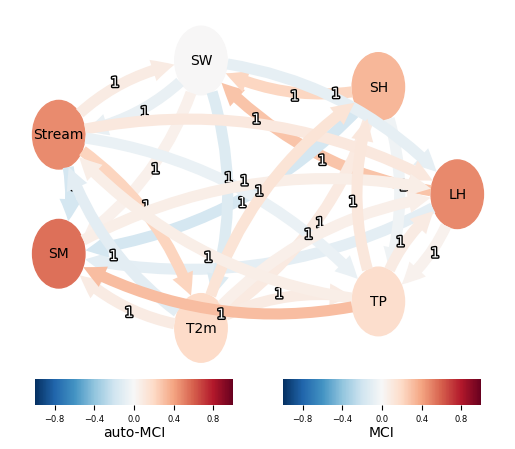

In [7]:
# Set hyperparameters
tau_min = 1
tau_max = 1
# pc_alpha = None
# alpha_level = 0.01

pcmci = PCMCI(dataframe=filled_tigramite_df,
              cond_ind_test=RobustParCorr())

pcmci_results = pcmci.run_pcmci(tau_min=tau_min, tau_max=tau_max)#, pc_alpha=pc_alpha, alpha_level=alpha_level)

tp.plot_graph(val_matrix=pcmci_results['val_matrix'],
              graph=pcmci_results['graph'], var_names=filled_tigramite_df.var_names,
              node_aspect=0.5, node_size=0.5
              )
plt.show()

In [8]:
model = Models(
    dataframe=filled_tigramite_df,
    model=LinearRegression(),
)
all_parents = pcmci.return_parents_dict(pcmci_results["graph"], pcmci_results["val_matrix"])
model.fit_full_model(all_parents)

{0: {'data_transform': None, 'model': LinearRegression()},
 1: {'data_transform': None, 'model': LinearRegression()},
 2: {'data_transform': None, 'model': LinearRegression()},
 3: {'data_transform': None, 'model': LinearRegression()},
 4: {'data_transform': None, 'model': LinearRegression()},
 5: {'data_transform': None, 'model': LinearRegression()},
 6: {'data_transform': None, 'model': LinearRegression()}}

In [9]:
y_trues = []
for i in range(len(all_parents)):
    Y = [(i, 0)]
    X = []
    Z = all_parents[i] # ensure the resulting y_true matches the length of the predicted values
    arr = filled_tigramite_df.construct_array(X, Y, Z,
                                    tau_max=tau_max,
                                    mask_type=None,
                                    cut_off="2xtau_max",
                                    remove_overlaps=True,
                                    verbosity=False)
    y_true = arr[0][0, :]
    y_trues.append(y_true)

In [10]:
predictions = model.predict_full_model(cut_off="2xtau_max",)

In [11]:
# compute RMSE for each variable
for i in range(len(predictions)):
    print(f"RMSE for variable {filled_pd_df.columns[i]}: {np.sqrt(np.mean((predictions[i] - y_trues[i]) ** 2))}")

RMSE for variable LH: 0.524512975970938
RMSE for variable SH: 0.7699920953813225
RMSE for variable SW: 0.73358910755807
RMSE for variable Stream: 0.46095128931662255
RMSE for variable SM: 0.1311814177051484
RMSE for variable T2m: 0.47639115194846077
RMSE for variable TP: 1.0167054623162584
